In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import h5py



In [11]:
def generate_T1_filename(year, month, day, hour, minute, second):
    date_code = f'{year}_{month}_{day}'
    time_code = f'{hour}_{minute}_{second}'
    return r'V:\QSimMeasurements\Measurements\5QV3_Triangle_Lattice\T1\T1_{}\T1_{}_{}_data.h5'.format(date_code, date_code, time_code)
    
def generate_T2_filename(year, month, day, hour, minute, second):
    date_code = f'{year}_{month}_{day}'
    time_code = f'{hour}_{minute}_{second}'
    return r'V:\QSimMeasurements\Measurements\5QV3_Triangle_Lattice\T2R\T2R_{}\T2R_{}_{}_data.h5'.format(date_code, date_code, time_code)
    

In [3]:
class T1_measurement:
    
    def __init__(self, qubit, filename, start_index=0):
        
        self.qubit = qubit
        self.filename = filename
        
        self.start_index = start_index
        
        self.times = None
        self.frequency = None
        self.IQ = None
        
        self.params = None
        self.errors = None
        self.T1_time = None
        
     
    def get_data(self):
        if self.data is None:
            self.data = acquire_data(self.filename)
        return self.data
    
    def get_times(self):
        if self.times is None:
            self.acquire_data()
        return self.times
        
    def get_IQ(self):
        if self.IQ is None:
            self.acquire_data()
        return self.IQ
        
    def get_frequency(self):
        if self.frequency is None:
            self.acquire_data()
        return self.frequency
    
    def get_T1(self):
        if self.T1_time is None:
            self.fit_T1()
        return self.T1_time
    
    def get_params(self):
        if self.params is None:
            self.fit_T1()
        return self.params
    
    def get_errors(self):
        if self.errors is None:
            self.fit_T1()
        return self.errors
    
    def acquire_data(self):
        self.times, self.IQ, self.frequency = acquire_data(self.filename)
        
    def fit_T1(self, guess=None):
        
        if guess is None:
            guess = [50, 1, 0]

        times = self.get_times()
        IQ = self.get_IQ()
        frequency = self.get_frequency()
        
        self.params, self.errors = exponential_fit(times[self.start_index:], IQ[self.start_index:], guess=guess)
        
        self.T1_time = self.params[0]
        
    def plot_T1_fit(self, fit_times=None):
            
        
            
        times = self.get_times()
        IQ = self.get_IQ()
        frequency = self.get_frequency()
        params = self.get_params()
        errors = self.get_errors()
        
        if fit_times is None:
            end_time = max(self.get_T1()*4, times[-1])
            fit_times = np.linspace(0, end_time, 101)
        
        plt.figure(figsize=(10, 5))
        plt.plot(times, np.array(IQ), '.-', label='Data')
        plt.plot(fit_times, exponential_fit_function(fit_times, *params), label='Fit')
        
        if self.frequency is not None:
            plt.title(str(self.qubit) + r' T1: %.3f $\pm$  %.3f $\mu$s at %.3f Mhz' % (params[0], errors[0], frequency))
        else:
            plt.title(str(self.qubit) + r' T1: %.3f $\pm$  %.3f $\mu$s' % (params[0], errors[0]))
        plt.xlabel("Time (us)")
        plt.ylabel("ADC (a.u.)")
        plt.legend()
        plt.show()



In [69]:
class T2_measurement:
    
    def __init__(self, qubit, filename, start_index=0, initial_guess=None, plot_guess=False):
        
        self.qubit = qubit
        self.filename = filename
        
        self.start_index = start_index
        self.initial_guess = initial_guess
        self.plot_guess = plot_guess
        
        self.times = None
        self.frequency = None
        self.IQ = None
        
        self.params = None
        self.errors = None
        self.T2_time = None

    def get_times(self):
        if self.times is None:
            self.acquire_data()
        return self.times
    
    def get_IQ(self):
        if self.IQ is None:
            self.acquire_data()
        return self.IQ
        
    def get_frequency(self):
        if self.frequency is None:
            self.acquire_data()
        return self.frequency
    
    def get_T2(self):
        if self.T2_time is None:
            self.fit_T2()
        return self.T2_time
    
    def get_params(self):
        if self.params is None:
            self.fit_T2()
        return self.params
    
    def get_errors(self):
        if self.errors is None:
            self.fit_T2()
        return self.errors
        
    def acquire_data(self):
        self.times, self.IQ, self.frequency = acquire_data(self.filename)
        
    
    def get_initial_guess(self):
        if self.initial_guess is None:
            self.initial_guess = [4, 1, np.pi/2, 1, 0]
        return self.initial_guess
        
        
    def fit_T2(self, guess=None):
        
        if guess is not None:
            self.initial_guess = guess
        guess = self.get_initial_guess()

        times = self.get_times()
        IQ = self.get_IQ()
        frequency = self.get_frequency()

        self.params, self.errors = ramsey_fit(times[self.start_index:], IQ[self.start_index:], guess=guess)

        self.T2_time = self.params[0]
        
    def plot_T2_fit(self, fit_times=None):
        
        times = self.get_times()
        IQ = self.get_IQ()
        frequency = self.get_frequency()
        params = self.get_params()
        errors = self.get_errors()
        
        if fit_times is None:
            end_time = max(self.get_T2()*4, times[-1])
            fit_times = np.linspace(0, end_time, 1001)
        
        plt.figure(figsize=(10, 5))
        plt.plot(times, np.array(IQ), '.-', label='Data')
        plt.plot(fit_times, ramsey_fit_function(fit_times, *params), label='Fit')
        if self.plot_guess:
            plt.plot(fit_times, ramsey_fit_function(fit_times, *self.get_initial_guess()), label='Guess')
        
       
        if self.frequency is not None:
            plt.title(str(self.qubit) + r' T2: %.3f $\pm$  %.3f $\mu$s at %.3f MHz ' % (params[0], errors[0], frequency))
        else:
            plt.title(str(self.qubit) + r' T2: %.3f $\pm$  %.3f $\mu$s' % (params[0], errors[0]))
        plt.xlabel("Time (us)")
        plt.ylabel("ADC (a.u.)")
        plt.legend()
        plt.show()


In [61]:
def acquire_data(filename):

    try:
        with h5py.File(filename, "r") as f:
            time = f['x_pts'][()]
            avgi = f['avgi'][()][0][0]
            avgq = f['avgq'][()][0][0]
            qfreq = f['qfreq'][()]
            rfreq = f['rfreq'][()]

            avgi_final = avgi[-1]
            avgq_final = avgq[-1]

            avgi -= avgi_final
            avgq -= avgq_final

            range_i = np.max(np.abs(avgi))
            range_q = np.max(np.abs(avgq))

            if np.abs(range_i) > np.abs(range_q):
                return time, avgi / range_i, qfreq
            return time, avgq / range_q, qfreq

    except KeyError:
        print(f"skipping {filename}")
        return None

def exponential_fit_function(x, T1, A, B):
    return A * np.exp(-x / T1) + B

def exponential_fit(times, points, guess):
    
#     plt.plot(times, points, label='data')
#     fit_times = np.linspace(times[0], times[-1], 1001)
#     plt.plot(fit_times, exponential_fit_function(fit_times, *guess), label='guess')
    
    
    fit_params, pCov = curve_fit(exponential_fit_function, times, points, p0=guess, maxfev=100000)
    perr = np.sqrt(np.diag(pCov))
    return fit_params, perr

def ramsey_fit_function(x, T2, freq, phase, A, B):
    #     return(np.cos(2 * np.pi * x * freq + phase) + B)
#     print(f'freq: {freq}')
    return A * np.exp(-x / T2) * np.cos(2 * np.pi * x * freq + phase) + B

def ramsey_fit(times, points, guess):
    fit_params, pCov = curve_fit(ramsey_fit_function, times, points, p0=guess, maxfev=100000)
    perr = np.sqrt(np.diag(pCov))
    return fit_params, perr

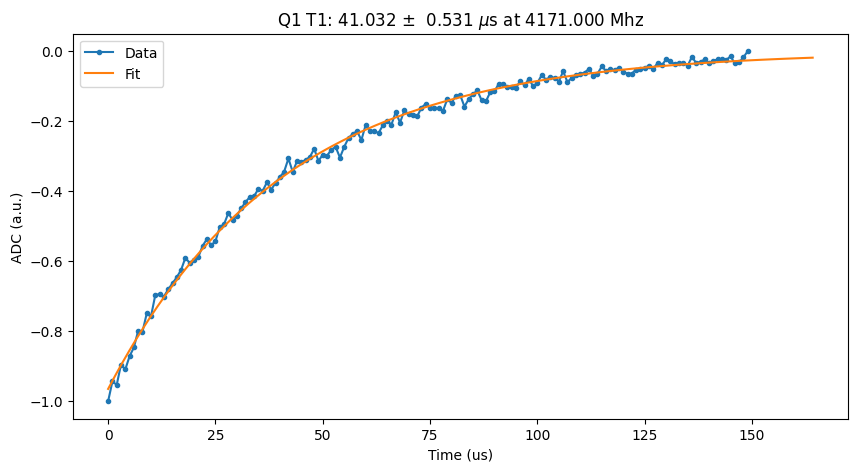

In [62]:
filename = generate_T1_filename('2025', '01', '15', '11', '21', '44')


test = T1_measurement('Q1', filename)

test.get_T1()
test.plot_T1_fit()

C:\Users\mattm\AppData\Local\Temp\ipykernel_12584\3507582914.py:45: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-x / T2) * np.cos(2 * np.pi * x * freq + phase) + B
C:\Users\mattm\OneDrive\Desktop\Research\Software\venv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


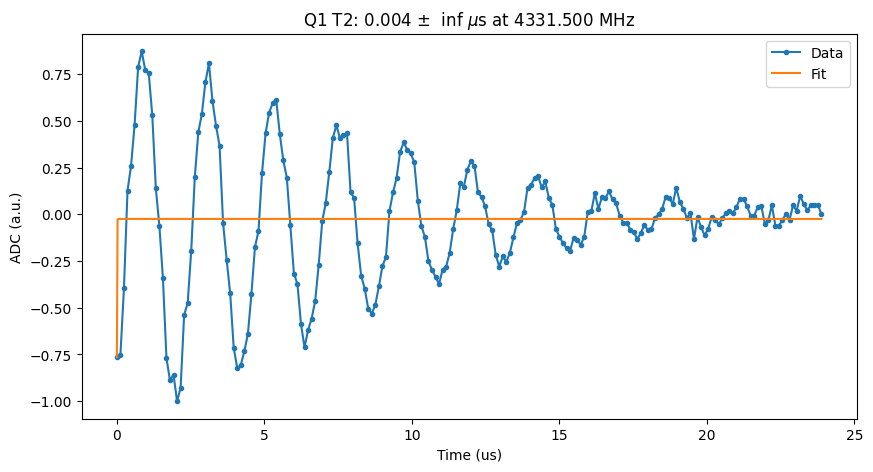

In [63]:
filename = generate_T2_filename('2025', '01', '14', '16', '33', '38')


test = T2_measurement('Q1', filename)

test.get_T2()
test.plot_T2_fit()

In [64]:
def create_measurement(qubit, filename):
    return T1_measurement(qubit, filename)

In [65]:
Q1_T1_measurements = []
Q2_T1_measurements = []
Q3_T1_measurements = []
Q4_T1_measurements = []
Q5_T1_measurements = []

qubit = 'Q1'
Q1_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '13', '16', '11', '07')))
Q1_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '11', '02', '05')))
Q1_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '11', '32', '14')))
Q1_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '13', '54', '24')))
Q1_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '15', '11', '21', '44')))


qubit = 'Q2'
Q2_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '09', '25', '13')))
Q2_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '15', '10', '24', '20')))
Q2_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '15', '15', '32', '59')))


qubit = 'Q3'
Q3_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '14', '52', '25')))
Q3_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '15', '16', '47', '40')))

qubit = 'Q4'
Q4_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '15', '17', '13')))

qubit = 'Q5'
Q5_T1_measurements.append(T1_measurement(qubit, generate_T1_filename('2025', '01', '14', '16', '26', '04')))


all_T1_measurements = []
all_T1_measurements.extend(Q1_T1_measurements)
all_T1_measurements.extend(Q2_T1_measurements)
all_T1_measurements.extend(Q3_T1_measurements)
all_T1_measurements.extend(Q4_T1_measurements)
all_T1_measurements.extend(Q5_T1_measurements)

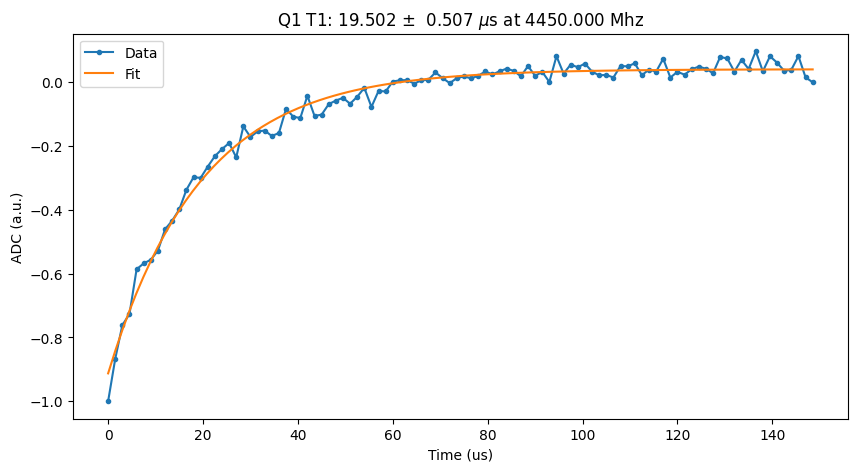

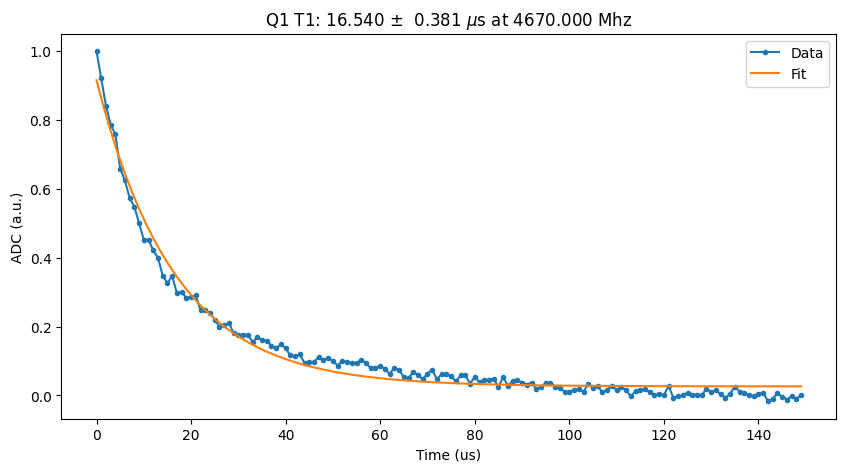

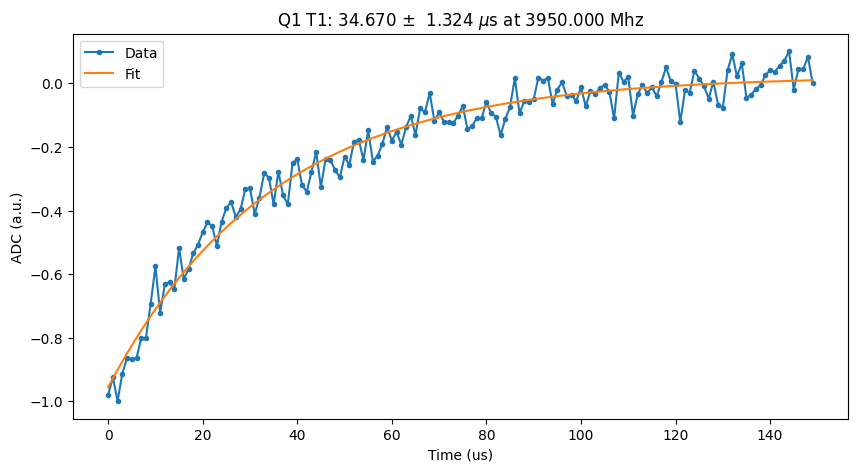

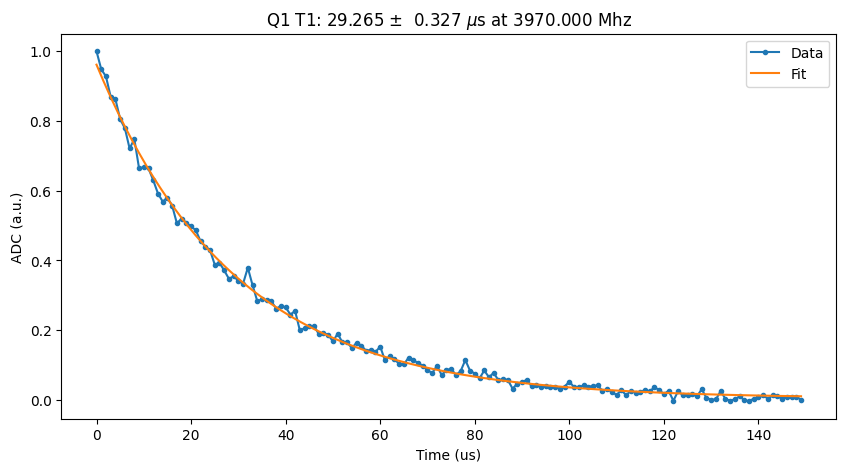

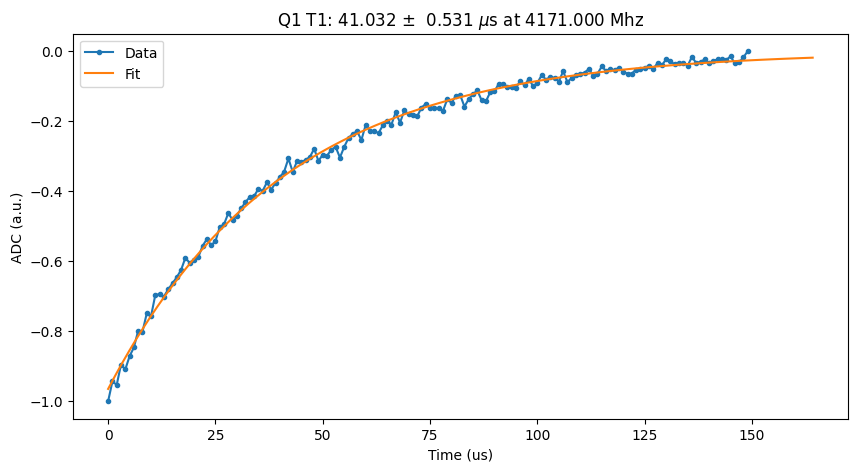

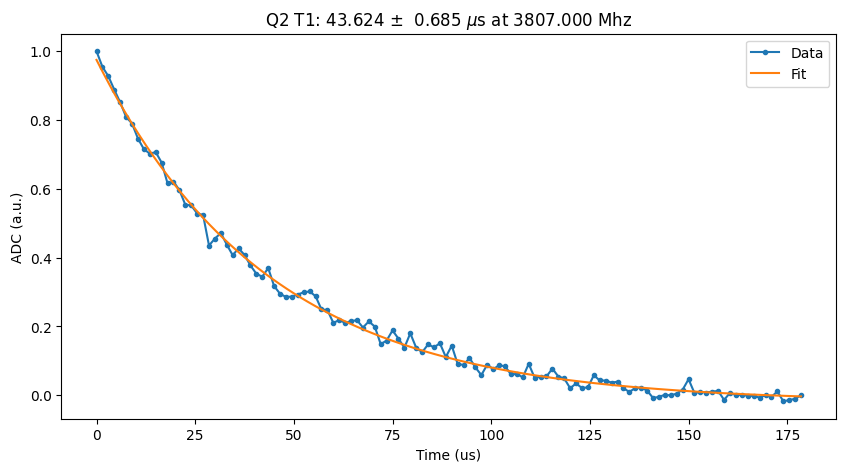

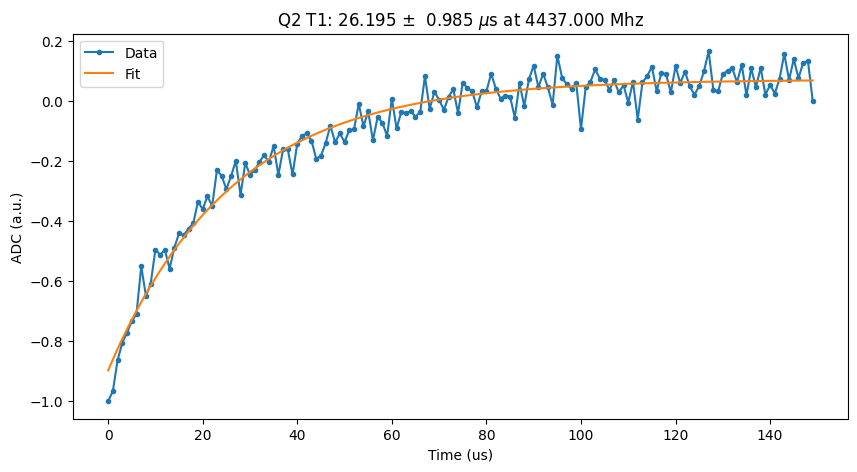

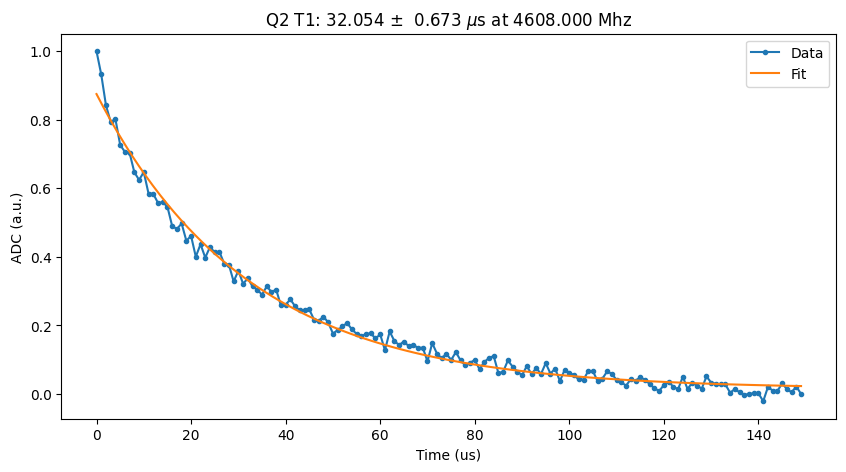

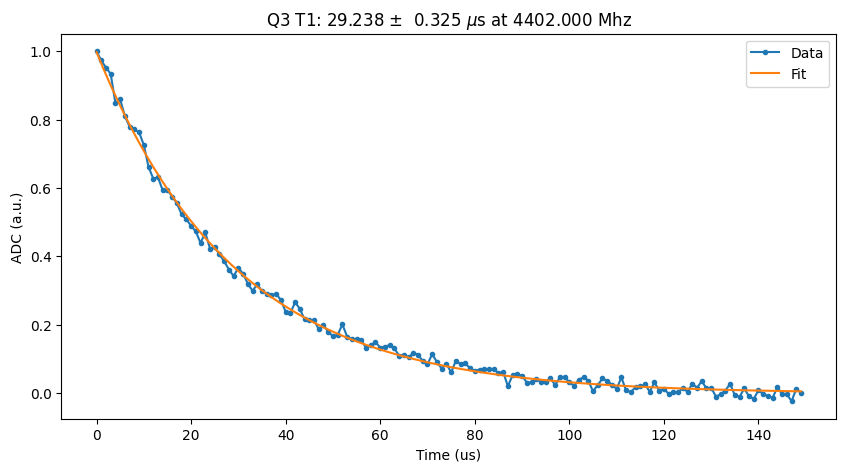

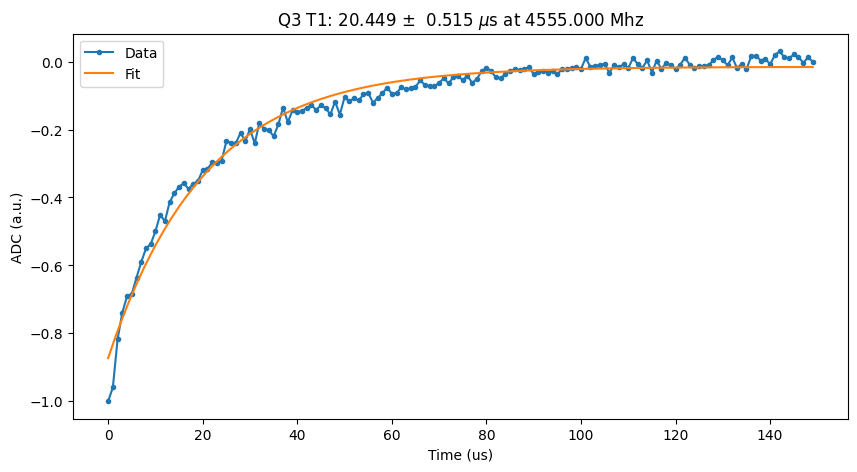

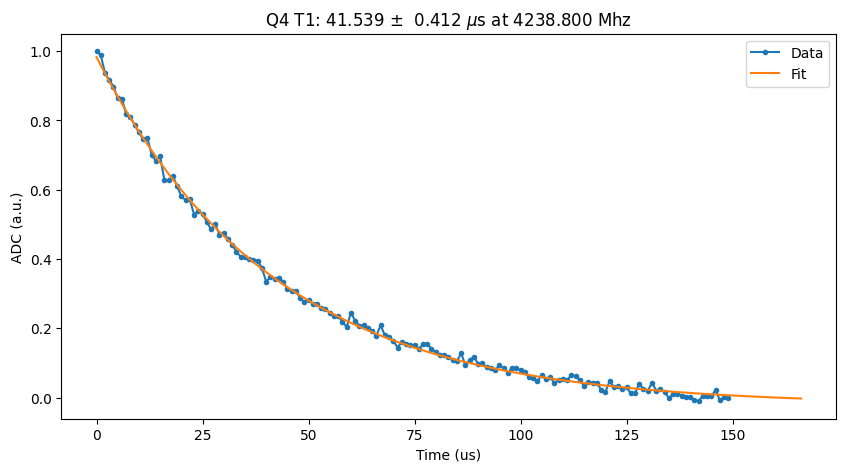

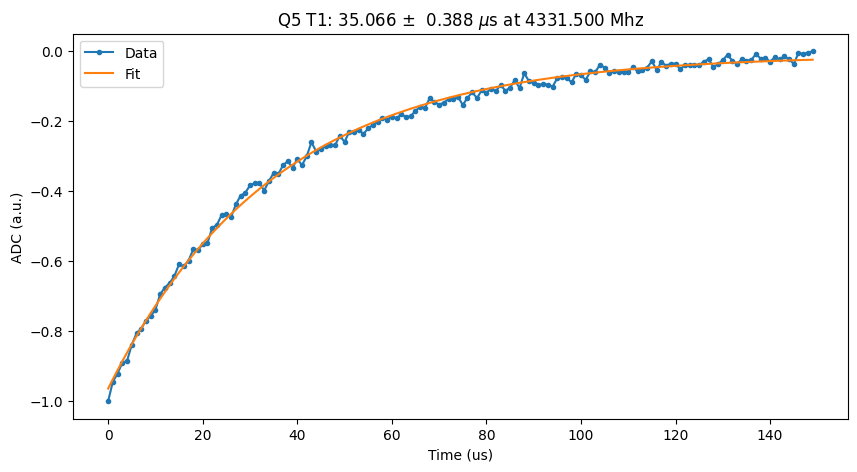

{'Q1': ([4450.0, 4670.0, 3950.0, 3970.0, 4171.0], [19.501774975476238, 16.539541485039447, 34.66996166780014, 29.265366110891453, 41.03208410777769]), 'Q2': ([3807.0, 4437.0, 4608.0], [43.62377657293909, 26.194639030457555, 32.05445765964747]), 'Q3': ([4402.0, 4555.0], [29.23753232928353, 20.44947351646346]), 'Q4': ([4238.8], [41.539176880578275]), 'Q5': ([4331.5], [35.06636431031824])}


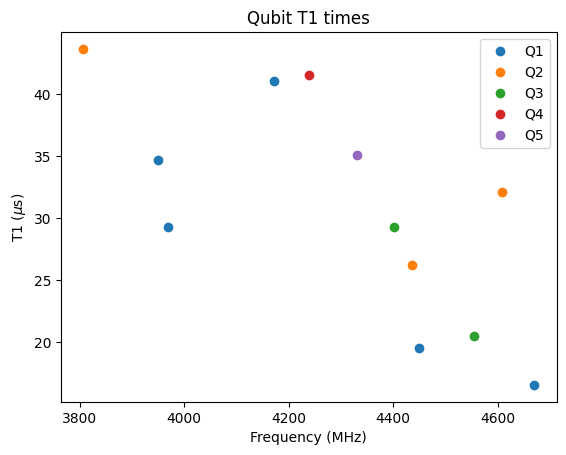

In [66]:
qubit_to_T1_vs_freqs = {f'Q{i+1}': ([], []) for i in range(5)}

for i in range(len(all_T1_measurements)):
    T1_measurement_i = all_T1_measurements[i]
    
    T1_measurement_i.plot_T1_fit()
    
    qubit = T1_measurement_i.qubit
    
    qubit_to_T1_vs_freqs[qubit][0].append(T1_measurement_i.get_frequency())    
    qubit_to_T1_vs_freqs[qubit][1].append(T1_measurement_i.get_T1())
    
print(qubit_to_T1_vs_freqs)

for i in range(5):
    qubit = f'Q{i+1}'
    
    plt.plot(qubit_to_T1_vs_freqs[qubit][0], qubit_to_T1_vs_freqs[qubit][1], linestyle='', marker='o', label=f'Q{i+1}')
    
plt.xlabel('Frequency (MHz)')
plt.ylabel('T1 ($\mu$s)')
    
plt.title('Qubit T1 times')
    
plt.legend()
plt.show()

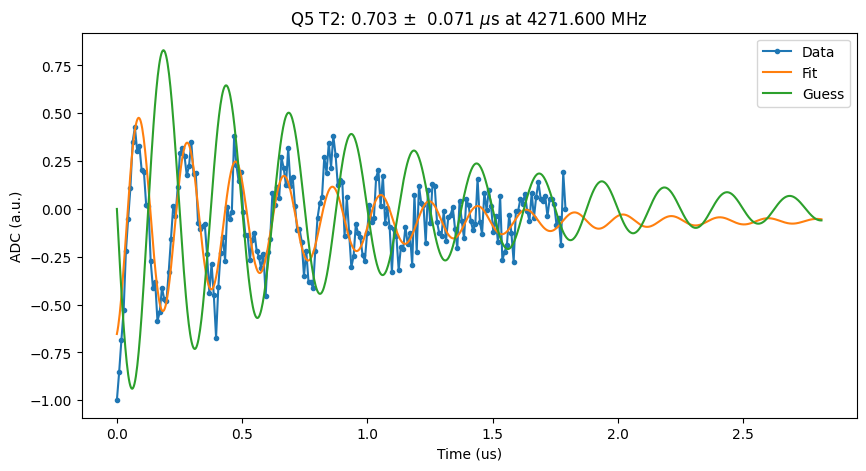

In [72]:
test = T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '13', '57', '17'), initial_guess=[1, 4, np.pi/2, 1, 0], plot_guess=True)
test.plot_T2_fit()

In [92]:
Q1_T2_measurements = []
Q2_T2_measurements = []
Q3_T2_measurements = []
Q4_T2_measurements = []
Q5_T2_measurements = []

qubit = 'Q1'
# Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '13', '16', '26', '07')))
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '13', '16', '31', '38')))
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '15', '11', '30', '52')))
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '13', '57', '17'), initial_guess=[1, 4, np.pi/2, 1, 0]))
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '16', '00', '46')))

# with FF
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '15', '10', '24')))
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '15', '23', '04')))

# with some FF
Q1_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '20', '16', '34', '19')))


qubit = 'Q2'
# bad fits, need to change initial guess probably
# Q2_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '14', '10', '26', '25')))
# Q2_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '15', '10', '34', '35')))
Q2_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '15', '16', '34', '26')))

qubit = 'Q3'
Q3_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '14', '15', '04', '44')))
Q3_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '16', '10', '30', '21')))

qubit = 'Q4'
Q4_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '14', '15', '29', '52')))
Q4_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '16', '11', '03', '07')))

qubit = 'Q5'
Q5_T2_measurements.append(T2_measurement(qubit, generate_T2_filename('2025', '01', '14', '16', '33', '38')))

all_T2_measurements = []
all_T2_measurements.extend(Q1_T2_measurements)
all_T2_measurements.extend(Q2_T2_measurements)
all_T2_measurements.extend(Q3_T2_measurements)
all_T2_measurements.extend(Q4_T2_measurements)
all_T2_measurements.extend(Q5_T2_measurements)



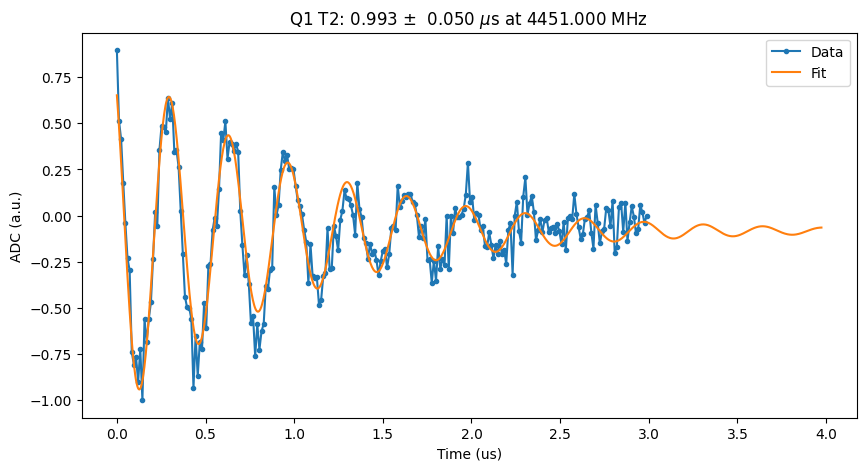

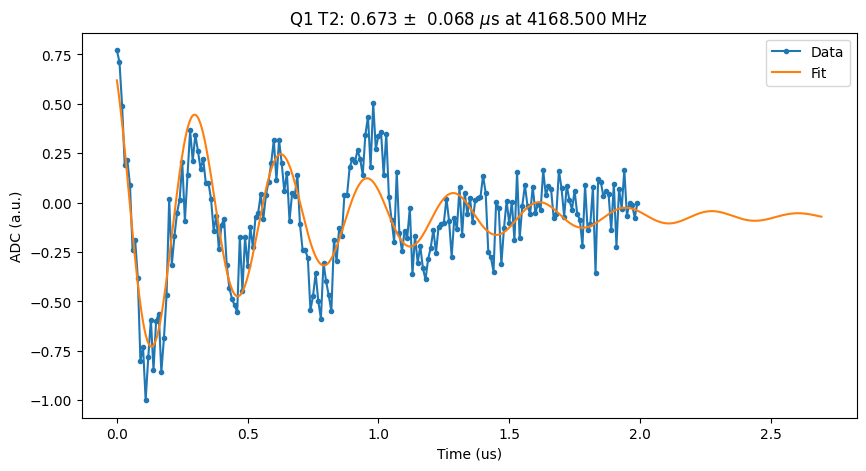

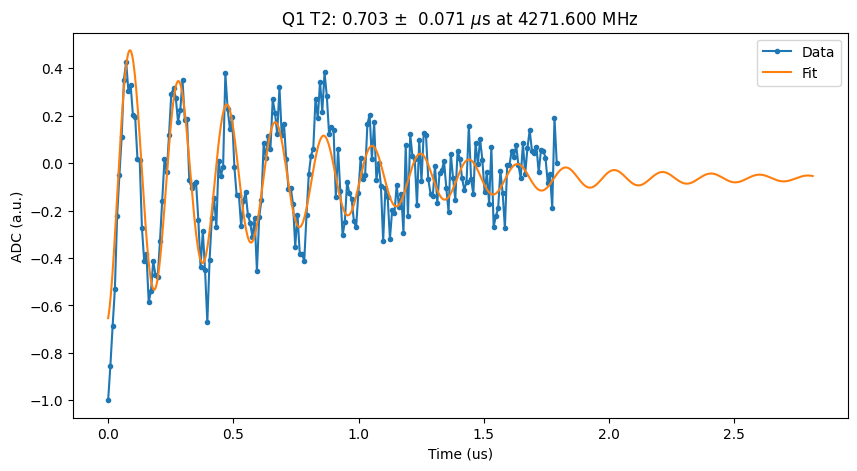

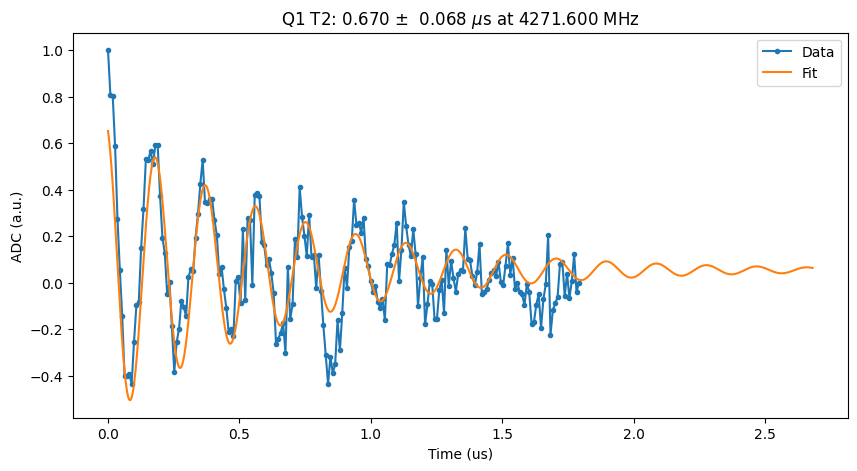

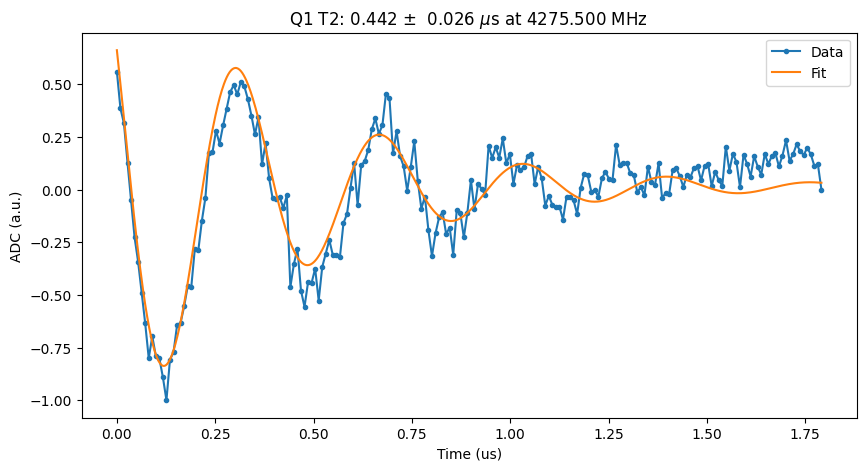

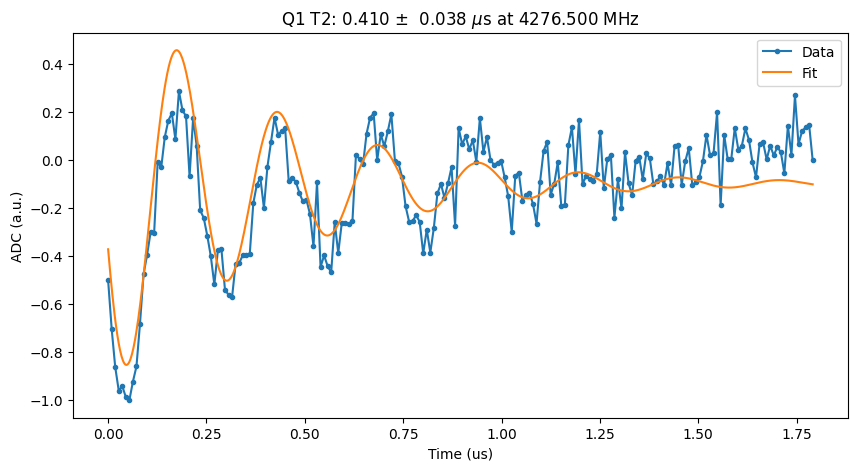

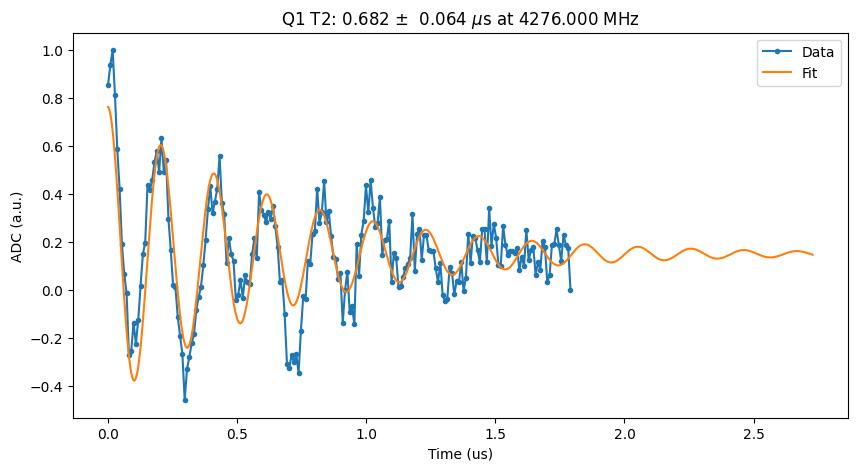

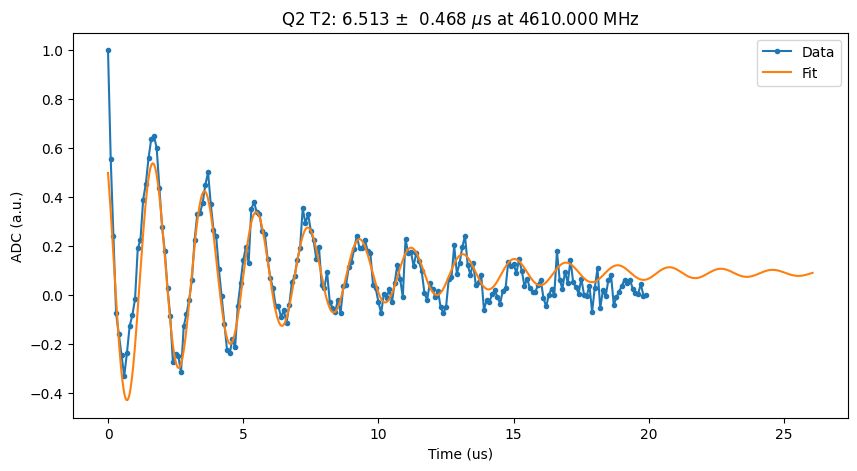

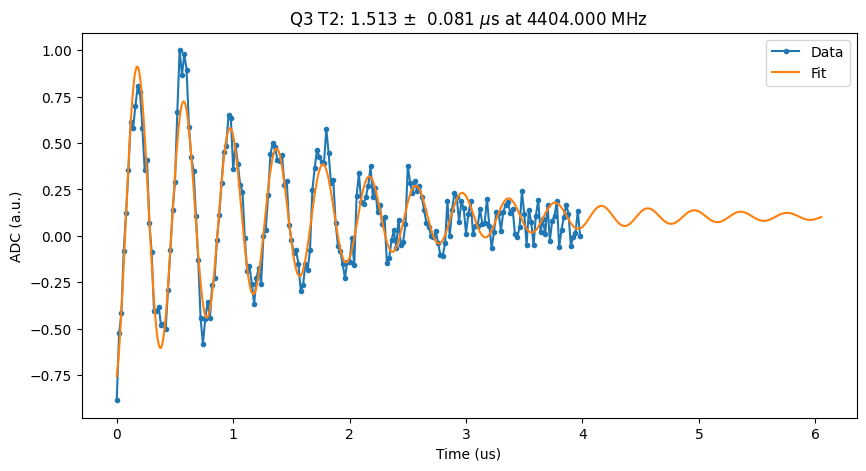

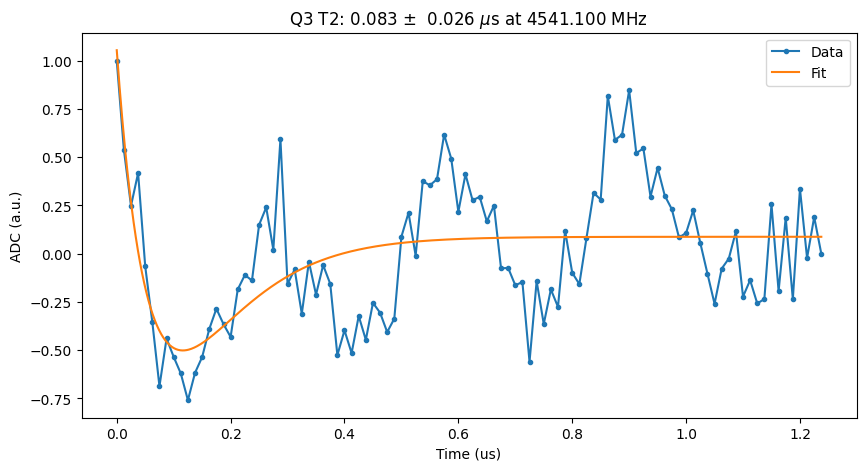

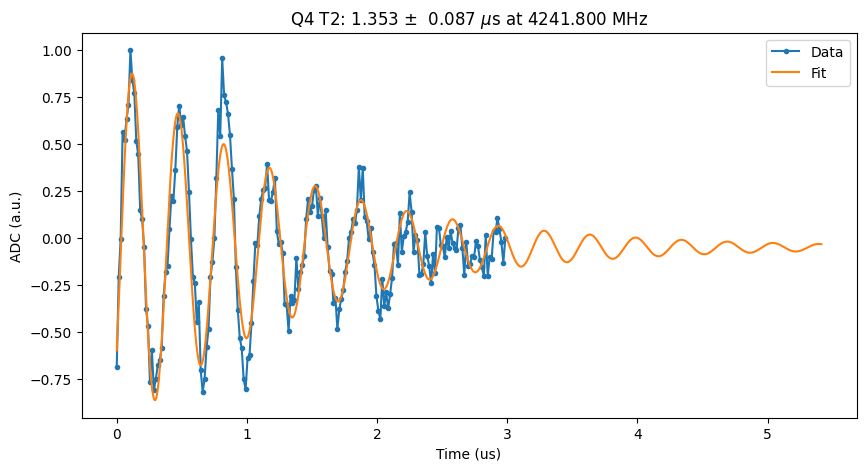

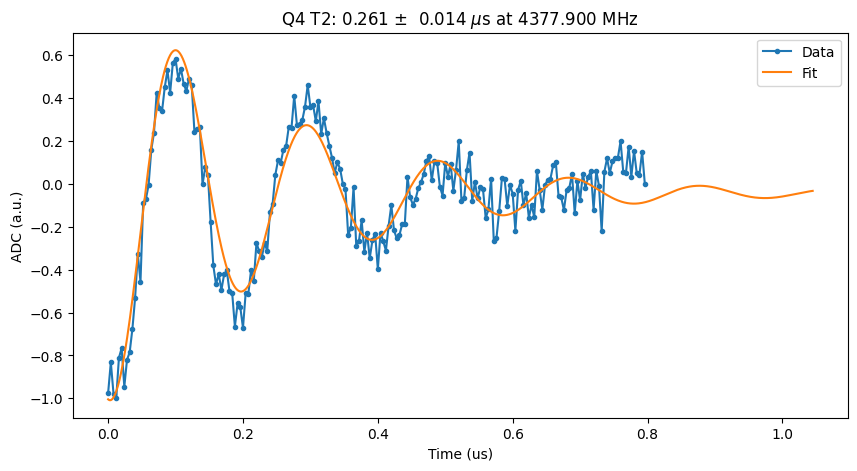

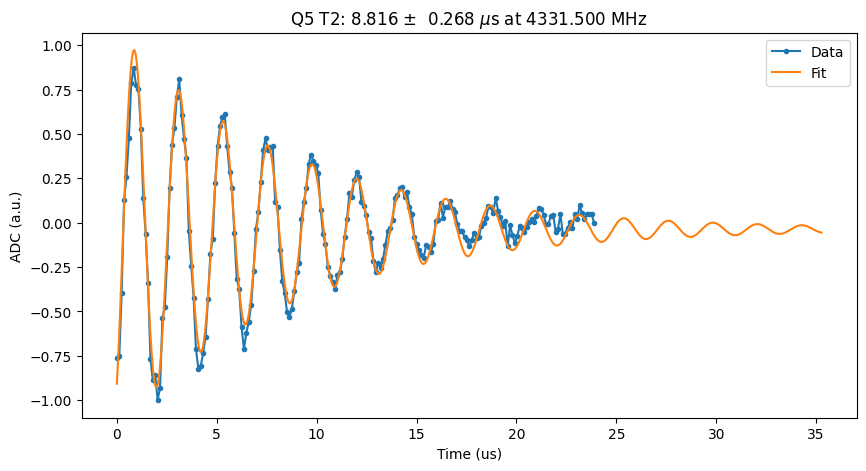

Q1
0.99
0.67
0.7
0.67
0.44
0.41
0.68
Q2
6.51
Q3
1.51
0.08
Q4
1.35
0.26
Q5
8.82


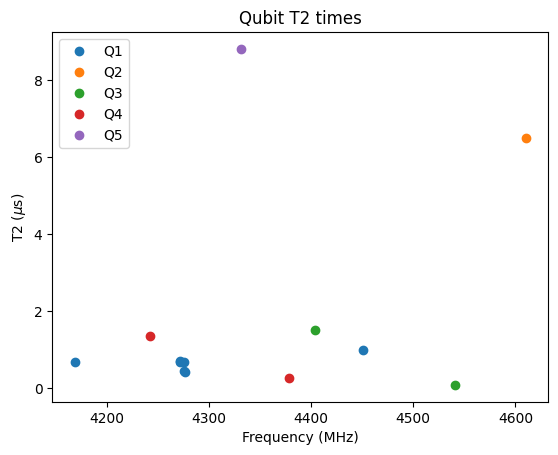

In [93]:
qubit_to_T2_vs_freqs = {f'Q{i+1}': ([], []) for i in range(5)}


for i in range(len(all_T2_measurements)):
    
    T2_measurement_i = all_T2_measurements[i]
    
    T2_measurement_i.plot_T2_fit()
    
    
    qubit = T2_measurement_i.qubit
    
    qubit_to_T2_vs_freqs[qubit][0].append(T2_measurement_i.get_frequency())    
    qubit_to_T2_vs_freqs[qubit][1].append(T2_measurement_i.get_T2())
    

for i in range(5):
    qubit = f'Q{i+1}'
    print(qubit)
    
    plt.plot(qubit_to_T2_vs_freqs[qubit][0], qubit_to_T2_vs_freqs[qubit][1], linestyle='', marker='o', label=f'Q{i+1}')
    for i in range(len(qubit_to_T2_vs_freqs[qubit][1])):
        print(np.round(qubit_to_T2_vs_freqs[qubit][1][i], 2))
    
plt.xlabel('Frequency (MHz)')
plt.ylabel('T2 ($\mu$s)')
    
plt.title('Qubit T2 times')
# plt.yscale('log')
    
plt.legend()
plt.show()